In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+556.gc74f9a74a.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 9.99 GB available memory.


In [6]:
from desc.particles import *
from desc.particles import _trace_particles
from diffrax import *

In [7]:
name = "precise_QA"

try:
    # if the file exists, load it
    eq = load(f"{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1)
    eqi_scaled = eq.copy()
    eq.save(f"{name}_vacuum_scaled_solved.h5")

eq.iota = eq.get_profile("iota")
model = VacuumGuidingCenterTrajectory(frame="flux")
ts = jnp.linspace(0, 1e-3, 1000)

def default_event(t, y, args, **kwargs):
    i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
    return jnp.logical_or(i < 0.0, i > 1.0)

event = Event(default_event)

n = 5
rhos = [0.3] * n
initializer = ManualParticleInitializerFlux(
    rho0=rhos,
    theta0=0,
    zeta0=np.random.rand(n) * 2 * np.pi,
    xi0=2 * np.random.rand(n) - 1,
    E=3.5e6,
    m=4.0,
    q=2.0,
)
x0, args = initializer.init_particles(model=model, field=eq)

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)


In [77]:
res = 1
interpolater = FourierChebyshevField(L=eq.L_grid*res, M=eq.M_grid*res, N=eq.N_grid*res)
interpolater.build(eq)
data_fit = interpolater.fit(eq.params_dict, {"iota": eq.iota})

In [78]:
rtz_1, _, aux_1 = _trace_particles(
    field=data_fit,
    y0=x0,
    model=model,
    model_args=args,
    ts=ts,
    params=None,
    max_steps=int((ts[-1] - ts[0]) / 1e-8),
    min_step_size=1e-8,
    stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
    saveat=SaveAt(ts=ts),
    solver=Tsit5(),
    adjoint=RecursiveCheckpointAdjoint(),
    event=event,
    chunk_size=None,
    options={},
    throw=False,
    return_aux=True,
)

In [79]:
aux_1[0]

{'max_steps': Array([100000, 100000, 100000, 100000, 100000], dtype=int64, weak_type=True),
 'num_accepted_steps': Array([ 156,  168,  282, 1104,  204], dtype=int64, weak_type=True),
 'num_rejected_steps': Array([ 63,  75, 123, 538,  73], dtype=int64, weak_type=True),
 'num_steps': Array([ 219,  243,  405, 1642,  277], dtype=int64, weak_type=True)}

In [50]:
rtz_2, _, aux_2 = _trace_particles(
    field=eq,
    y0=x0,
    model=model,
    model_args=args,
    ts=ts,
    params=eq.params_dict,
    max_steps=int((ts[-1] - ts[0]) / 1e-8),
    min_step_size=1e-8,
    stepsize_controller=PIDController(rtol=1e-4, atol=1e-4, dtmin=1e-8),
    saveat=SaveAt(ts=ts),
    solver=Tsit5(),
    adjoint=RecursiveCheckpointAdjoint(),
    event=event,
    chunk_size=None,
    options={},
    throw=False,
    return_aux=True,
)

In [51]:
aux_2[0]

{'max_steps': Array([100000, 100000, 100000, 100000, 100000], dtype=int64, weak_type=True),
 'num_accepted_steps': Array([ 157,  168,  284, 1112,  205], dtype=int64, weak_type=True),
 'num_rejected_steps': Array([ 62,  71, 130, 562,  82], dtype=int64, weak_type=True),
 'num_steps': Array([ 219,  239,  414, 1674,  287], dtype=int64, weak_type=True)}

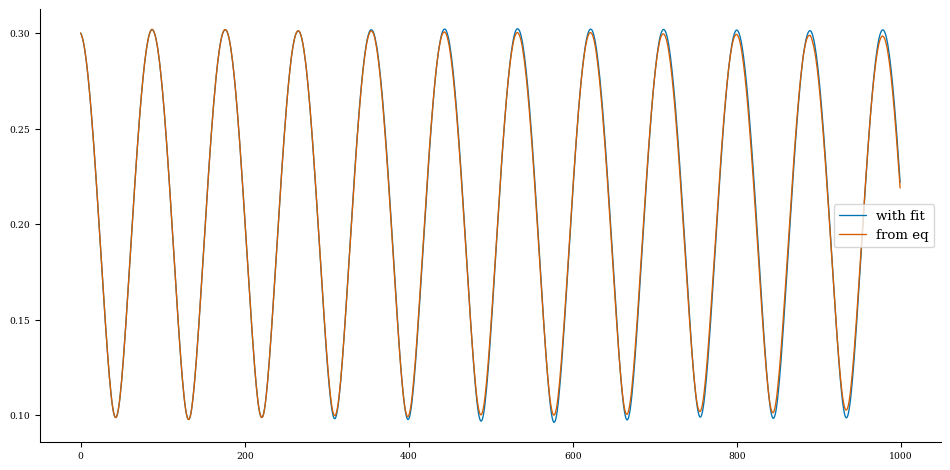

In [74]:
particle_id = 0
plt.figure(figsize=(10, 5))
plt.plot(rtz_1[particle_id, :, 0], label="with fit")
plt.plot(rtz_2[particle_id, :, 0], label="from eq")
plt.legend();

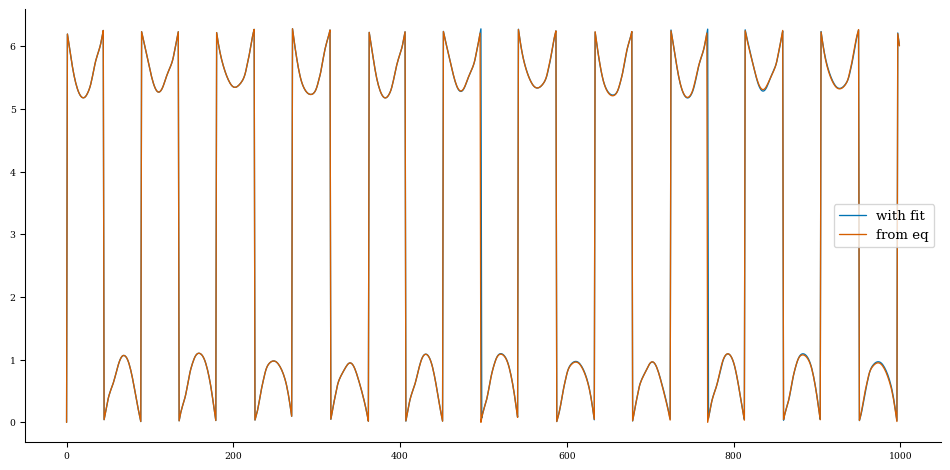

In [75]:
particle_id = 1
plt.figure(figsize=(10, 5))
plt.plot(rtz_1[particle_id, :, 1], label="with fit")
plt.plot(rtz_2[particle_id, :, 1], label="from eq")
plt.legend()

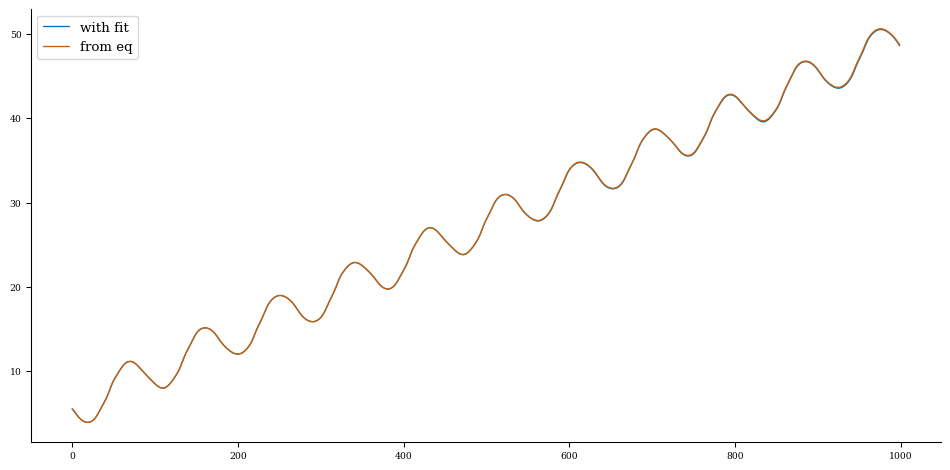

In [76]:
particle_id = 1
plt.figure(figsize=(10, 5))
plt.plot(rtz_1[particle_id, :, 2], label="with fit")
plt.plot(rtz_2[particle_id, :, 2], label="from eq")
plt.legend()